# Machine Project 2: Webscraping & Data Analysis, Git Analysis, and Benchmarking


#### <span style="color:red">Make sure to read the [README](README.md) before starting this project</span>

## Required Information

Please fill out the following details.  
- Enter your **full name (as it appears on Canvas)** and **NetID**.  
- This project must be completed **individually**

> **Important:** Each student must submit the project individually.  
Failure to complete this section may result in your submission being flagged for plagiarism.

In [1]:
# Project: MP2
# Student 1: vardaan kapoor, vkapoor5

## <span style="color:red">Important:</span>

* **Before you begin**, make sure to `pull` any changes from GitLab. From the terminal, run:
```
git checkout main
git pull
git checkout MP2
git merge main
```
* Follow all instructions carefully. If anything is unclear, attend office hours or post on Piazza.
* You may add additional code cells as needed. However, **only cells with `#Q_` in the code will be graded**.
* To test, **Restart and Run all Cells** then **save the notebook** and run `python3 tester.py` from the terminal

> ⚠️ **Reminders:**
>
> - Make sure you are on the `MP2` branch by running `git branch` and checking the output.
> - Frequently `add`, `commit`, and `push` your code to avoid losing progress.


In [2]:
# Add additional imports used throughout the project here

import pickle # used for grading graphs
from bs4 import BeautifulSoup
import pandas as pd
from collections import Counter
from subprocess import check_output,STDOUT,CalledProcessError
import re
import numpy as np
import time
import matplotlib.pyplot as plt

## Part 1: HTML Review
> 📄 **Work in:** [`mp2.ipynb`](mp2.ipynb)

This first part of the project will serve as a review of some basic HTML and webscraping concepts.

### Q1: What is the email listed under the contact information in `sample.html`?

Your output must be a **string** representing the email listed under the "Contact Section" of `sample.html`. 

**Hint:** Consider opening the HTML file and looking at it to get familiar with its structure. 

**Hint:** Begin by opening `sample.html`, then use `beautifulsoup4` to parse the html content and find the email. Use `find` to locate the "Contact Section" and find the email.

**Note:** You must **not** hardcode the solution

In [3]:
#Q1
with open('sample.html',"r") as f:
    contents=f.read()
    soup=BeautifulSoup(contents,'html.parser')
    contact_section = soup.find(id="contact")
    if contact_section:
        email_tag = contact_section.find("a", href=lambda href: href and href.startswith("mailto:"))
        email_candidate=email_tag.text
    else:
        email_candidate=None
email_candidate
        
    


'contact@example.com'

### Requirement: Rankings DataFrame

For the next few questions, you'll be tasked with analyzing and extracting world university rankings from a pre-saved HTML file, `rankings.html`, adapted from the [CWUR rankings](https://cwur.org/2020-21.php). To ensure efficiency and avoid overloading the original webpage with multiple requests, we've provided a local copy for all students. The goal of this first part is to parse the provided HTML file to collect and analyze data. 


Use BeautifulSoup to parse `rankings.html`, find the table containing the ranking data, and then save it as a Pandas DataFrame. You do not have to perform any typecasting of the data yet. **This DataFrame will be used in Q2-Q4**

**Hint:** Use `find` or `find_all` to identify the table and its header.

In [4]:



with open("rankings.html", "r", encoding="utf-8") as f:
    contents = f.read()


soup = BeautifulSoup(contents, "html.parser")


table = soup.find("table", id="cwurTable")


header_cells = table.find("thead").find_all("th")
columns = [cell.get_text(strip=True) for cell in header_cells]


rows = []
for tr in table.find("tbody").find_all("tr"):
    cells = [td.get_text(strip=True) for td in tr.find_all("td")]
    rows.append(cells)


rankings_df = pd.DataFrame(rows, columns=columns)




### Q2: What is the highest-ranked institution in **Germany**?

Your output must be a **string** representing the name of this institution.


In [5]:
#Q2
# Ensure the 'World Rank' column is numeric so sorting works correctly
rankings_df['World Rank'] = rankings_df['World Rank'].astype(int)


# Filter to only German entries
germany = rankings_df[rankings_df['Country'] == "Germany"]
# Sort by world rank ascending and grab the first institution
top_german_details = germany.iloc[0]

top_german_details["Institution"]


'Ludwig Maximilian University of Munich'

### Q3: List the **lowest 10** institutions in the USA that were ranked **better** than the highest-ranked institution in **Germany**?

Your output must be a **list** containing the names of the **lowest 10** universities from USA with a better World Rank than the best German institution. By better ranked, we refer to institutions with a lower value under the `World Rank` column.

**Hint:** Get a list of **all** the universities from USA with a better rank than the best ranked German university, and then return the last 10 items of the list.

**Important:** Keep in mind that the datatype of the values in the dataframe will initially be `string`. You will need to convert them to `numeric` in order to compare rankings. Consider using `pd.to_numeric()`.


In [6]:
#Q3

best_german_rank=top_german_details['World Rank']


usa_better_sorted = rankings_df[
    (rankings_df['Country'] == "USA") &
    (rankings_df['World Rank'] < best_german_rank)
]

lowest_10 = usa_better_sorted['Institution'].iloc[-10:]


lowest_10.tolist()


['Duke University',
 'University of Illinois at Urbana–Champaign',
 'University of Washington - Seattle',
 'University of Wisconsin–Madison',
 'New York University',
 'University of Texas at Austin',
 'University of California, San Diego',
 'University of California, San Francisco',
 'University of North Carolina at Chapel Hill',
 'Dartmouth College']

### Q4: What are the top five highest-ranked institutions based on `Research Rank` in **India**?

Your output must be a **list** of institutions **sorted in increasing order** of their `Research Rank`.

**Hint:** For sorting a DataFrame based on the values of a particular column, you can use the `DataFrame.sort_values(by="column_name")` method (where `column_name` is the column on which you want to sort).

**Important:** Keep in mind that the datatype of the values in the dataframe will initially be `string`. You will need to convert them to `numeric` in order to compare rankings. Consider using `pd.to_numeric()`.


In [7]:
#Q4


rankings_df['Research Rank'] = pd.to_numeric(rankings_df['Research Rank'], errors='coerce')

india_df = rankings_df[rankings_df['Country'] == 'India']
top_research_details=india_df.sort_values(by='Research Rank')

top_5=top_research_details.head(5)["Institution"]

top_5.tolist()


['Indian Institute of Science',
 'Tata Institute of Fundamental Research',
 'Indian Institute of Technology Bombay',
 'Indian Institute of Technology Madras',
 'University of Delhi']

## Part 2: Project History Analysis
> 📄 **Work in:** [`mp2.ipynb`](mp2.ipynb)

We have a copy of the flask repo in `flask.zip`.  Run `unzip flask.zip`.  If `unzip` is not installed, follow the suggestion in the error message to install it. If that suggestion doesn't work, try running it again, but adding `sudo` in front of it. This will run the command with root privileges. Now, try running `unzip flask.zip` again.


### Q5: What is the first line of output from `git log` when run in the `flask` repo directory?

**Important:** Do not remove the first line of code. Because you will use `git checkout` commands (as required for following exercises) to switch the current (HEAD) commit, the output of `git log` will change (it will show the current commit and prior ones, but not future commits).  So you need to run `git checkout main` to bring the HEAD back to the latest commit before your code for this question.  Otherwise your answer to this question might only be correct the first time you run the notebook.

If you pass `cwd="????"` to `check_output` with your desired directory, you can run the `git log` command inside the `flask` directory that was created when you ran the `git clone` command.  "CWD" stands for "change working directory". For example, if I wanted to run `git branch` inside of a directory called `test-directory`, I could run the following code: `check_output(["git", "branch"], cwd="test-directory")`.

The `check_output` function in the `subprocess` module (https://docs.python.org/3.10/library/subprocess.html#subprocess.check_output) returns a byte sequence; consider converting it to a string ("utf-8" encoding) and splitting it by newline (`\n`) to get a list. Save this list as a variable. This will be useful for answering the following questions.

**Note:** All code for this question must be written directly in the Jupyter Notebook, and there must not be any hardcoding of values.


In [8]:
check_output(["git", "checkout", "main"], cwd="flask") # DO NOT REMOVE

Already on 'main'


b"Your branch is up to date with 'origin/main'.\n"

In [9]:
#Q5
output=str(check_output(["git","log"],cwd="flask"),encoding="utf-8").strip()
allLines=output.split("\n")
firstLineOfFirstCommit=allLines[0]
firstLineOfFirstCommit

'commit 660994efc761efdfd49ca442b73f6712dc77b6cf'

### Q6: What are the commit numbers of the 10 earliest commits?

Answer with a list. Commits with earlier timestamp should be later in the list. 
If you created a list in the last question of all of the lines, all you will need to do is filter out the "commit" lines, and properly slice that list.
(Hint: Since `git log` puts earlier commits later in the output, you don't need to reorder the commits.)

**Note:** All code for this question must be written directly in the Jupyter Notebook, and there must not be any hardcoding of values.


In [10]:
#Q6
commitIds=output.split("commit ")[-10:]
commitIds
listFinal=[]
for commit in commitIds:
    commitId=commit.split("\n")[0]
    listFinal.append(commitId)
listFinal
    

['a9d4ea81da28ee9c894bf9d45adc4cfa9d52fddc',
 '727c701686c18c4a27ca523eb0c5862d497be24e',
 '4edec48b74dbb9d571e927b69b24c30ec0624975',
 '625eba4bb403296a8bbc1e72cc9cf4a5126f6c02',
 '4aa76212d1be9b17a57249549c2a73fb10b6cda8',
 '3b36bef2e6165bb4dad73d17f23ee1879e99f497',
 '44b42e0fbd93d86e0f4e929bda8e5fb63e81035d',
 '4ec7d2a0d8eac4f915dc0d38a886cd57045bb0c4',
 'b15ad394279fc3b7f998fa56857f334a7c0156f6',
 '33850c0ebd23ae615e6823993d441f46d80b1ff0']

### Q7: What did the `README` file contain after the 100th commit?

Use `check_output` to run a `git checkout` command to switch to that commit, before reading `flask/README` the way you would read any regular text file in Python (using `open` and `.read`).

**Note**: If you are not able to find a file called `flask/README` and instead see `flask/README.md` or `flask/README.rst`, then you are on the wrong commit.

**Note:** All code for this question must be written directly in the Jupyter Notebook, and there must not be any hardcoding of values.



In [11]:
#Q7

# 1. Make sure you’re back on main
check_output(["git", "checkout", "main"], cwd="flask")

# 2. Build the list of commit hashes in chronological order
log = check_output(["git", "log", "--reverse", "--format=%H"], cwd="flask")
commits = log.decode("utf-8").splitlines()

# 3. Grab the 100th commit (index 99)
commit_100 = commits[99]

# 4. Check out that commit
check_output(["git", "checkout", commit_100], cwd="flask")

# 5. Read the README file at that commit
with open("flask/README", "r", encoding="utf-8") as f:
    readme_at_100 = f.read()

readme_at_100


Already on 'main'
Note: switching to 'f878919753a909e45b2d5448aa175f4f9129ff24'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at f8789197 With -> with in headline


"\n                          // Flask //\n\n         because sometimes a pocket knife is not enough\n\n\n    ~ What is Flask?\n\n      Flask is a microframework for Python based on Werkzeug\n      and Jinja2.  It's intended for small scale applications\n      and was development with best intentions in mind.\n\n    ~ Is it ready?\n\n      A preview release is out now, and I'm hoping for some\n      input about what you want from a microframework and\n      how it should look like.  Consider the API to slightly\n      improve over time.\n\n    ~ What do I need?\n\n      Jinja 2.4 and Werkzeug 0.6.1.  `easy_install` will\n      install them for you if you do `easy_install Flask==dev`.\n      I encourage you to use a virtualenv.  Check the docs for\n      complete installation and usage instructions.\n\n    ~ Where are the docs?\n\n      Go to http://flask.pocoo.org/ for a prebuild version of\n      the current documentation.  Otherwise build them yourself\n      from the sphinx sources i

### Q8: How many pull requests were merged from each GitHub user?  Only output users who appear 10 or more times.

When running `git log`, you'll see some entries like this:

```
commit 7b0c82dfdc867641dd6e1b200f735bffd66e4c12
Merge: c5ca1750 a841cfab
Author: David Lord <davidism@gmail.com>
Date:   Wed Dec 22 17:10:24 2021 -0800

    Merge pull request #4350 from olliemath/patch-1
    
    Only use a custom JSONDecoder if needed
```

This means the code was approved by David Lord (who has permission to make changes), but the code change was written and proposed by olliemath.

Whenever a line from `git log` contains the text "Merge pull request" and "/", extract the username immediately before the "/".  Count occurrences of usernames in a dictionary like the following:

```
{'pallets': 204,
 'pgjones': 14,
 'greyli': 42,
 'ThiefMaster': 11,
 'davidism': 45,
 'untitaker': 20,
 'ThomasWaldmann': 13,
 'SimonSapin': 11}
```

**Note**: There will be some entries like the following that are actually undoing a pull request:

```
Revert "Merge pull request #859 from wvh/register_error_handler"
```

For simplicity, we'll count these just like the original pull requests.

**Important:** If your values are off/incorrect, it is likely that you are on the wrong branch/commit. Make sure that you are on **main**. 

**Note:** All code for this question must be written directly in the Jupyter Notebook, and there must not be any hardcoding of values.


In [12]:
check_output(["git", "checkout", "main"], cwd="flask") # DO NOT REMOVE

Previous HEAD position was f8789197 With -> with in headline
Switched to branch 'main'


b"Your branch is up to date with 'origin/main'.\n"

In [13]:
#Q8



subjects = check_output(
    ["git", "log", "--pretty=format:%s"],
    cwd="flask"
).decode("utf-8").splitlines()


pattern = re.compile(r"Merge pull request #\d+ from ([^/]+)/")
users = [m.group(1) for subj in subjects if (m := pattern.search(subj))]


counts = Counter(users)


merged_prs_per_user = {user: cnt for user, cnt in counts.items() if cnt >= 10}

merged_prs_per_user


{'pallets': 204,
 'pgjones': 14,
 'greyli': 42,
 'ThiefMaster': 11,
 'davidism': 45,
 'untitaker': 20,
 'ThomasWaldmann': 13,
 'SimonSapin': 11}

### Q9: What is the output of `pip3 instal`?  (yes, the misspelling was intentional)

This one will be difficult because the command will fail, triggering
an exception.  First, run this by itself to determine what exception
type is thrown in this circumstance:

```python
check_output(["pip3", "instal"])
```

Now, adapt this code to get the output, regardless of whether the program runs or fails:

Search the page here to learn about the exception type, and import it: https://docs.python.org/3/library/subprocess.html

Then, use that information to catch exceptions of that type (fill in the missing exception type):

```python
import subprocess

try:
    msg = check_output(["pip3", "instal"], stderr=subprocess.STDOUT)
except subprocess.???? as e:
    msg = e.output
```

Note that `stderr=subprocess.STDOUT` tells `check_output` that error
messages should be treated as regular output -- that lets us capture
the output with `e.output`.

**Hint:** Consider using `decode()` to convert binary outputs to string type.

**Note:** All code for this question must be written directly in the Jupyter Notebook, and there must not be any hardcoding of values.


In [14]:
#Q9

try:
    # Attempt the misspelled pip command, capturing stderr as stdout
    msg = check_output(
        ["pip3", "instal"],
        stderr=STDOUT
    )
except CalledProcessError as e:
    # CalledProcessError is raised when the command exits with non-zero status
    msg = e.output

# Decode the byte output to a UTF-8 string
output_str = msg.decode("utf-8")
output_str


'ERROR: unknown command "instal" - maybe you meant "install"\n'

## Part 3: Benchmarking
> 📄 **Work in:** [`mp2.ipynb`](mp2.ipynb)

In this final part of the machine project, we will work on some benchmarking. This will allow us
to time things to see how long they take which gives us a good idea as to what methods
or functions are faster. It is recommended that you try to remember that we did this testing
as we will be using these functions throughout the semester and opting for the faster options
will optimize you code later in the semester.

### Q10: What is faster for looping over a DataFrame, `iterrows` or `itertuples`?

We'll want to generate test data of various sizes. The actual values of this data is irrelevant, we just need something to loop through for timing of different methods. Use the provided function `rand_df` for that purpose.

Answer with a plot as follows:
* x-axis is number of number of rows in a DataFrame
* y-axis is milliseconds is how long it takes to loop over the DataFrame
* two lines: one for `iterrows` and one for `itertuples`

You can generate a random DataFrame with 500 rows like this:

```python
df = rand_df(500)
```

And then you can take a measurement like this:

```python
import time

t0 = time.time()
# HOW LONG DOES THIS TAKE TO RUN, FOR DATAFRAMES WITH DIFFERENT NUMBERS OF ROWS?
for row in df.iterrows():
    pass
t1 = time.time()
```

Your plot should look something like this. Some noise is OK as long as you get the same general shape (we get a slightly different plot each time we measure ourselves).

**_Make sure to include a title, axis labels, and a legend_**

**Important:** The labels of the lines must be `iterrows` and `itertuples` as shown below

<img src="img/q10.png" width="400px">

In [15]:
def rand_df(rows):
    return pd.DataFrame(np.random.randint(10, size=(rows, 5)),
                        columns=["A", "B", "C", "D", "E"],
                        index=[f"r{i}" for i in range(1, rows+1)])

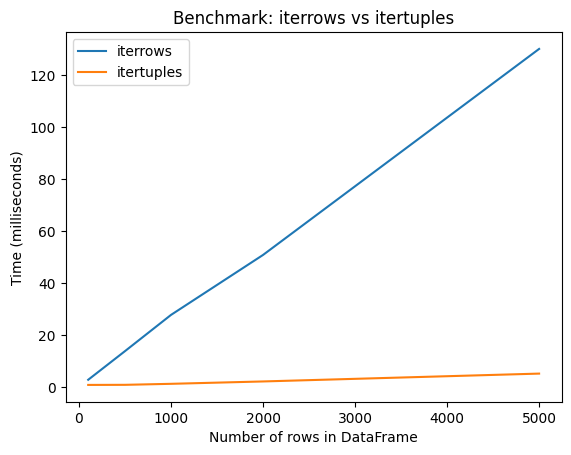

In [16]:
#Q10

# 1. Choose DataFrame sizes to test
row_counts = [100, 500, 1000, 2000, 5000]

# 2. Containers for timings (in ms)
times_iterrows = []
times_itertuples = []

# 3. Benchmark loops
for n in row_counts:
    df = rand_df(n)

    # iterrows timing
    t0 = time.time()
    for _ in df.iterrows():
        pass
    times_iterrows.append((time.time() - t0) * 1000)

    # itertuples timing
    t0 = time.time()
    for _ in df.itertuples():
        pass
    times_itertuples.append((time.time() - t0) * 1000)

# 4. Plot results
fig, ax = plt.subplots()
ax.plot(row_counts, times_iterrows, label="iterrows")
ax.plot(row_counts, times_itertuples, label="itertuples")
ax.set_title("Benchmark: iterrows vs itertuples")
ax.set_xlabel("Number of rows in DataFrame")
ax.set_ylabel("Time (milliseconds)")
ax.legend()

# 5. Save figure for submission (do not remove)
with open("Q10.pkl", "wb") as f:
    pickle.dump(fig, f)

plt.show()
plt.close()

### Q11: What is faster, `loc`, or `at`?

Answer with a line plot, similar to the one for the previous question.  Here is a code snippet to use for the measurement (adapt to measure `.at` as well):

```python
# HOW LONG DOES THIS TAKE TO RUN, FOR DATAFRAMES WITH DIFFERENT NUMBERS OF ROWS?
total = 0
for idx in df.index:
    for col in df.columns:
        total += df.loc[idx, col]
```

**_Make sure to include a title, axis labels, and a legend_**

**Important:** The labels of the lines must be `.loc` and `.at` as shown below

<img src="img/q11.png" width="400px">

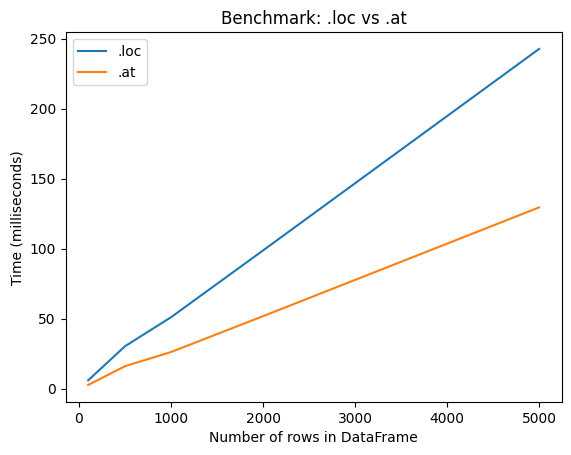

In [17]:
#Q11

row_counts = [100, 500, 1000, 2000, 5000]
times_loc = []
times_at = []

for n in row_counts:
    df = rand_df(n)
    
    # Timing .loc
    t0 = time.time()
    total = 0
    for idx in df.index:
        for col in df.columns:
            total += df.loc[idx, col]
    times_loc.append((time.time() - t0) * 1000)  # milliseconds
    
    # Timing .at
    t0 = time.time()
    total = 0
    for idx in df.index:
        for col in df.columns:
            total += df.at[idx, col]
    times_at.append((time.time() - t0) * 1000)  # milliseconds

# Plotting
fig, ax = plt.subplots()
ax.plot(row_counts, times_loc, label=".loc")
ax.plot(row_counts, times_at, label=".at")
ax.set_title("Benchmark: .loc vs .at")
ax.set_xlabel("Number of rows in DataFrame")
ax.set_ylabel("Time (milliseconds)")
ax.legend()

# Save figure for Q11
with open("Q11.pkl", "wb") as f:
    pickle.dump(fig, f)

plt.show()
plt.close()

### Q12: What is faster, a loop or `.apply`?

Answer this one with a line plot similar to the last two.  You should, however, have measurements going up to 20000 rows.

The two code snippets to measure:

```python
# HOW LONG DOES THIS TAKE TO RUN, FOR DATAFRAMES WITH DIFFERENT NUMBERS OF ROWS?
result = df["A"].apply(laugh).tolist()
```

AND

```python
# HOW LONG DOES THIS TAKE TO RUN, FOR DATAFRAMES WITH DIFFERENT NUMBERS OF ROWS?
result = []
for val in df["A"]:
    result.append(laugh(val))
```

Use the `laugh` function provided below

**_Make sure to include a title, axis labels, and a legend_**

**Important:** The labels of the lines must be `apply` and `loop` as shown below

<img src="img/q12.png" width="400px">

In [18]:
def laugh(x):
    return "qwerty" * x

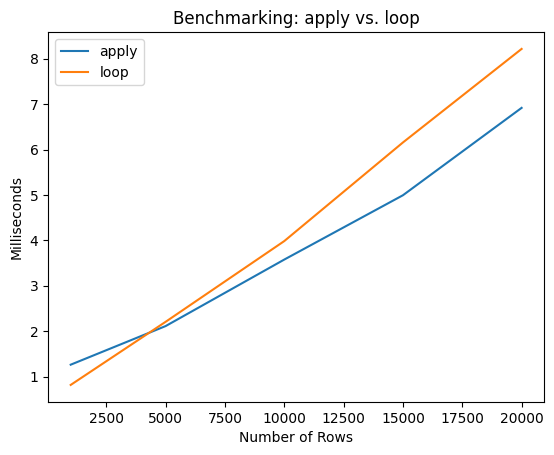

In [19]:
#Q12

row_counts = [1000, 5000, 10000, 15000, 20000]
times_apply = []
times_loop = []

for n in row_counts:
    # Use a constant value (5) for every row so timings are stable
    df = pd.DataFrame({"A": [5] * n})
    
    # Measure .apply
    t0 = time.time()
    _ = df["A"].apply(laugh).tolist()
    times_apply.append((time.time() - t0) * 1000)
    
    # Measure Python loop
    t0 = time.time()
    result = []
    for val in df["A"]:
        result.append(laugh(val))
    times_loop.append((time.time() - t0) * 1000)

# Plotting
fig, ax = plt.subplots()
ax.plot(row_counts, times_apply, label="apply")
ax.plot(row_counts, times_loop, label="loop")
ax.set_title("Benchmarking: apply vs. loop")
ax.set_xlabel("Number of Rows")
ax.set_ylabel("Milliseconds")
ax.legend()

# IMPORTANT -- Do not remove --
with open("Q12.pkl", "wb") as f:
    pickle.dump(fig, f)

plt.show()
plt.close(fig)

## <span style="color:red">Important:</span>
Make sure to follow these steps to submit the project
1. **Kernel > Restart Kernel and Run All Cells** and then save the notebook
2. Run `tester.py` to check your answers
3. Run the following commands from the terminal:
```
git status # make sure you are in the correct branch
git add <required files>
git commit -m "Some message"
git push
```
4. Once you've pushed your project to GitLab, **verify that the pipeline ran successfully**.
    * Build > Jobs > Select the latest commit hash > Check tester output
5. Create a **_merge request_** to submit the project
    * Code > Merge requests > New merge request